# Homework Assignment 1
### The Art of Analyzing Big Data- The Data Scientist’s Toolbox 

For this homework you will need to write code that analyzes real-world datasets. The code needs to be written in Python using the [sqlite3](https://docs.python.org/2/library/sqlite3.html) package. 


# Babies Names Dataset

**Task 1 (for everyone):** Write a code that uses the  [babies names dataset](https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-data-by-state-and-district-of-#topic=developers_navigation) and creates a table named (Names) with the dataset data and the following columns: 'State', 'Gender', 'Name', 'Number' (5pt)
**Bonus:** Load the data using a Batch INSERT SQL Query (5pt)

In [65]:
import sqlite3
import os
"""
A Db file with the babies names dataset was created before to be use with this assingment.
"""
Db_Path = '../datasets/'
Db_name = 'Names1'

db = sqlite3.connect(f'{Db_Path}{Db_name}.db')
c = db.cursor()
c.execute("create table Names(State, Gender, Year INT, Name, Number INT)")
directory = os.fsdecode(Db_Path+'babynames')

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    with open(os.path.join(directory, filename), "r") as input_file:
        records = [tuple(line.rstrip('\n').split(',')) for line in input_file]
    c.executemany("insert into Names values (?,?,?,?,?);", records)
db.commit()



**Task 2:** Write a query that returns the statistics for the name Mary (5pt). Use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run (5pt). [Create an index](https://www.w3schools.com/sql/sql_create_index.asp)  on the _Name_ column and use the [the timeit package](https://docs.python.org/3/library/timeit.html) to measure the time it takes the query to run with the index (10pt)

In [66]:
%%timeit
# Part 1 - running query without index
query = """SELECT Year, sum(NUMBER) as c FROM Names Where Name=='Mary' GROUP BY Year """
c.execute(query)

3.17 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [67]:
index_query = "CREATE INDEX name_index ON Names(Name)"
c.execute(index_query)


In [68]:
%%timeit
# Part 1- running query with index
query = """SELECT Year, sum(NUMBER) as c FROM Names Where Name=='Mary' GROUP BY Year """
c.execute(query)

264 ms ± 6.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


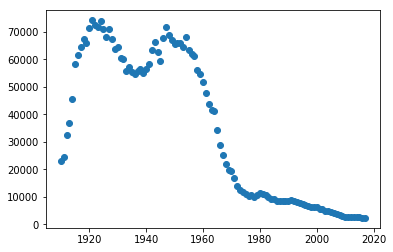

In [69]:
# Show babies named 'Mary' distrubution over the years.
import matplotlib.pyplot as plt
%matplotlib inline
query = """SELECT Year, sum(NUMBER) as c FROM Names Where Name=='Mary' GROUP BY Year """
year_list = []
count_list = []
for row in c.execute(query):
    year_list.append(row[0])
    count_list.append(row[1])
plt.scatter(year_list, count_list)
plt.show()

***Question 1:*** Write a function that returns how many babies were born in a given state in a given year.
Use it to calculate the number of babies born in LA in 1950 (15pt)

In [17]:
def calc_babies_in_year_and_state(state,year):
    query = """SELECT sum(number) FROM Names WHERE State==? AND Year==?"""
    print("there were {} babies born in {} in the year {}".format( c.execute(query, (state, year)).fetchone()[0],state,year))

calc_babies_in_year_and_state('NY',1910)

there were 48148 babies born in NY in the year 1910


**Question:** For the state of NY write code that calculates the second most popular female/male names in each decade in each state (10pt). Visualize it somehow using Matplotlib (5pt)

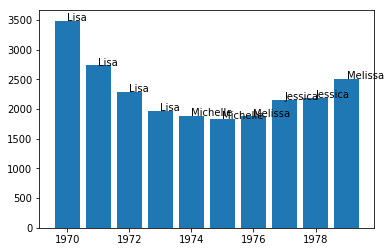

In [86]:
def second_max_for_decade(state,decade,gender):

    query = '''SELECT Name, Year, MAX(Number) as Second_Max
            FROM Names
            NATURAL JOIN 
                (SELECT Year, MAX(Number) AS Max_decade
                FROM Names
                WHERE State=? AND Year / 10 = ? AND Gender = ?
                GROUP BY Year)
            WHERE State=? AND Year / 10 = ? AND Gender = ? AND Number != Max_decade
            GROUP BY Year'''
    return c.execute(query,(state,decade,gender,state,decade,gender))

a = second_max_for_decade('NY',197,'F')
names,years,maxs = [], [], []
for record in a.fetchall():
    names.append(record[0])
    years.append(record[1])
    maxs.append(record[2])
    
fig, ax = plt.subplots()
ax.bar(years, maxs)
for i, txt in enumerate(names):
    ax.annotate(txt, (years[i], maxs[i]))
plt.show()

In [87]:
c.close()
db.close()

# Flavors of Cacao Dataset

Using the [Flavors of Cacao](https://www.kaggle.com/rombikuboktaeder/choco-flavors) dataset, answer the following questions:

**Question 1:** Write a function that returns the number of bars manufactured where the bars' BroadBean Origin is a given country. Use the function to calculate the number of bars where BroadBean Origin is 'Fiji' (15 pt)

In [88]:
Db_Path = '../datasets/'
Db_name = 'flavors_of_cacao'

db = sqlite3.connect(f'{Db_Path}{Db_name}.db')
c = db.cursor()

def calc_num_of_bars_in_state(country):
    query = '''Select count(DISTINCT Specific_Bean_Origin_or_Bar_Name) FROM Cacao
                WHERE Broad_Bean_Origin=? '''
    return c.execute(query,(country,)).fetchone()[0]

print(calc_num_of_bars_in_state('Fiji'))
c.close()
db.close()

6


# Kickstarter Projects Dataset

Using the [Kickstarter Projects Dataset](https://www.kaggle.com/kemical/kickstarter-projects#ks-projects-201801.csv), answer the following questions:

**Question 1:** On average which project category received the highest pledged USD? (15 pt)

In [89]:
Db_Path = '../datasets/'
Db_name = 'ks18'

db = sqlite3.connect(f'{Db_Path}{Db_name}.db')
c = db.cursor()

query = '''select avg(usdpledged) as avgU ,category from 
            ksProjects
            group by category order by avgU desc limit 0,1'''

print("on average the project category that received the highest pledged USD is: {}".format(c.execute(query).fetchone()[1]))

c.close()
db.close()

on average the project category that received the highest pledged USD is: 3D Printing


### Oscars Datasets

Using the [Oscars Dataset](https://www.kaggle.com/theacademy/academy-awards), answer the following questions:

**Question 1:** Who is the female actress with the most Oscar nominees? (10pt)

In [90]:
Db_Path = '../datasets/'
Db_name = 'Oscar'

db = sqlite3.connect(f'{Db_Path}{Db_name}.db')
c = db.cursor()
query = '''select count(*) as cnt,Name from Oscar
where Award like '%Actress%'
group by Name order by cnt desc limit 0,1'''
print("the female actress with most oscar nominees is: {}".format(c.execute(query).fetchone()[1]))

c.close()
db.close()

the female actress with most oscar nominees is: Meryl Streep


## Select a Dataset

**Open Question:** Select an interesting dataset and use SQL to discover something interesting (10pt)

There is a very common joke about superheros that superheroes writes, like stan lee, were lazy and a lot of the time gave their character first and last names that start with the same letter like peter parker, sue storm and more. lets see if that really the case!

In [55]:
Db_Path = '../datasets/'
Db_name = 'marvel'

db = sqlite3.connect(f'{Db_Path}{Db_name}.db')
c = db.cursor()

query1 = "Select count(*) from marvel_dc_characters"
num_of_characters = c.execute(query1).fetchone()[0]

query2 = """SELECT count(*) as cnt FROM ( 
	SELECT substr(first_name,1,1) AS sub1, substr(last_name,1,1) AS sub2	
	from(
		SELECT 
			substr(name, 1, instr(name, ' ') - 1) AS first_name,
			substr(name,    instr(name, ' ') + 1) AS last_name
		from marvel_dc_characters))
where sub1=sub2"""
num_of_characters_with_same_letter = c.execute(query2).fetchone()[0]

print("""acording to the database and unlike common joke 
only {}% of comicbook heroes have the same first letter 
in their first and last name""".format(round((num_of_characters_with_same_letter/num_of_characters)*100, 2)))


acording to the database and unlike common joke 
only 5.38% of comicbook heroes have the same first letter 
in their first and last name
